## Base Layer Config

In [1]:
from pydantic import BaseModel
import numpy as np
from typing import List, Tuple, Dict, Any, Union
from pathlib import Path


class BaseLayerConfig(BaseModel):
    name: str = "BaseLayer"
    layer_size: Tuple[int, int] = (1000, 1000)
    layer_background: Union[Path, Tuple[int, int, int]] = Path("../assets/me.jpg")
    # applied on layer when it is created
    layer_alpha: int = 255
    layer_visible: bool = True
    layer_locked: bool = False
    allow_children: bool = True
    allow_parent: bool = True
    resize_if_needed: bool = True
    layer_position: Tuple[int, int] = (0, 0)
    steps: int = 2

    class Config:
        arbitrary_types_allowed = True

## Some Helper Functions

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from typing import Tuple, List, Optional



def subplot_images(
    image: List[np.ndarray],
    titles: Optional[List[str]] = None,
    fig_size: Tuple[int, int] = (10, 10),
    order: Tuple[int, int] = (1, 1),
    axis: bool = False,
    show: bool = False,
):
    """
    A function to plot multiple images in a subplot.

    Args:
    image: List of images to plot.
    titles: List of titles for each image.
    fig_size: Size of the figure.
    cmap: Colormap for the images.
    order: Tuple of number of rows and columns for the subplot.
    axis: Whether to show axis or not.

    Returns:
    fig: Figure object.

    """

    if len(image) == 1:
        return show_image(
            image[0],
            titles[0] if titles else None,
            fig_size if fig_size else (5, 5),
            axis,
        )

    order = (
        (order[0], len(image) // order[0])
        if order[1] == -1
        else (len(image) // order[1], order[1]) if order[0] == -1 else order
    )

    fig, axs = plt.subplots(order[0], order[1], figsize=fig_size)
    if order[0] == 1 and order[1] == 1:
        axs = np.array([axs])
    for i, ax in enumerate(axs.flatten()):
        ax.imshow(image[i], vmax=255, vmin=0)
        if titles:
            ax.set_title(titles[i])
        if not axis:
            ax.axis("off")
    if show:
        plt.show()
    return fig

## Base Modifier

In [3]:
from abc import ABC, abstractmethod
from PIL import Image
import cv2

class BaseModifier(ABC):
    @abstractmethod
    def modify(self, image: Union[np.ndarray, Image.Image]) -> Image.Image:
        pass
    @property
    def name(self):
        return f"{self.__class__.__name__}()"
    def __repr__(self):
        return self.name

class ImageFlip(BaseModifier):
    def __init__(self, flip_axis: int=0):
        self.flip_axis = flip_axis

    def modify(self, image = Union[np.ndarray, Image.Image]) -> Image.Image:
        if isinstance(image, np.ndarray):
            image = Image.fromarray(image)
            
        return image.transpose(self.flip_axis)

class ImageRotate(BaseModifier):
    def __init__(self, angle: int=0):
        self.angle = angle

    def modify(self, image = Union[np.ndarray, Image.Image]) -> Image.Image:
        if isinstance(image, Image.Image):
            image = np.array(image)
        
        rotation_matrix = cv2.getRotationMatrix2D((image.shape[1]//2, image.shape[0]//2), self.angle, 1)
        return Image.fromarray(cv2.warpAffine(image, rotation_matrix, (image.shape[1], image.shape[0])))

class AlphaModifier(BaseModifier):
    def __init__(self, alpha: int=255):
        self.alpha = alpha

    def modify(self, image = Union[np.ndarray, Image.Image]) -> Image.Image:
        if isinstance(image, Image.Image):
            image = np.array(image)
        
        image[..., 3] = self.alpha
        return Image.fromarray(image)



## Base Transformer

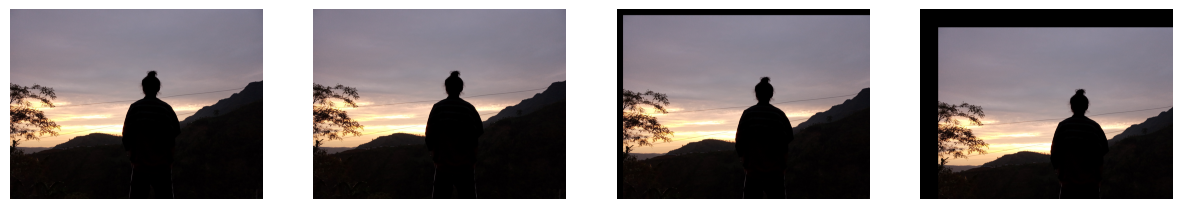

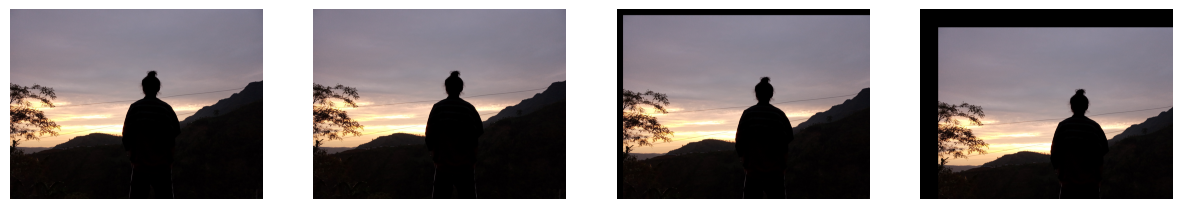

In [4]:
class BaseTransformer(ABC):
    def __init__(self, steps: int = 1, is_parallel: bool = False):
        steps - max(steps, 1)
        self.is_parallel = is_parallel
        self.steps = steps
        self.current_step = 0
        self.last_transformation = None
    
    @property
    def name(self):
        return f"{self.__class__.__name__}()"

    def __repr__(self) -> str:
        return self.name

    @abstractmethod
    def _transform(self, image: np.ndarray) -> Image.Image:
        pass

    def transform(
        self,
        image: Union[np.ndarray, Image.Image],
    ) -> Image.Image:
        if self.current_step < self.steps:
            self.last_transformation = self._transform(image)

        self.current_step += 1
        return self.last_transformation

    @property
    def name(self):
        return f"{self.__class__.__name__}()"


class ImageTranslator(BaseTransformer):

    def __init__(
        self, x: int = 0, y: int = 0, steps: int = 1, is_parallel: bool = False
    ):
        super().__init__(steps, is_parallel)
        self.x = x
        self.y = y
        self.delta_x = self.x / self.steps if self.steps <= 0 else self.x
        self.delta_y = self.y / self.steps if self.steps <= 0 else self.y

    def _transform(self, image: Union[np.ndarray, Image.Image]) -> Image.Image:
        if isinstance(image, Image.Image):
            image = np.array(image)

        if self.current_step > self.steps:
            curr_x = self.x
            curr_y = self.y
        else:
            curr_x = self.delta_x * self.current_step
            curr_y = self.delta_y * self.current_step
        # print(curr_x, curr_y, self.delta_x, self.delta_y)

        translation_matrix = np.float32([[1, 0, curr_x], [0, 1, curr_y]])
        return Image.fromarray(
            cv2.warpAffine(image, translation_matrix, (image.shape[1], image.shape[0]))
        )


class ImageScaler(BaseTransformer):

    def __init__(
        self,
        scale_x: float = 1.0,
        scale_y: float = 1.0,
        steps: int = 1,
        is_parallel: bool = False,
    ):
        super().__init__(steps, is_parallel)
        self.scale_x = scale_x
        self.scale_y = scale_y

        # Calculate incremental scaling factors
        self.delta_x = (self.scale_x - 1) / self.steps
        self.delta_y = (self.scale_y - 1) / self.steps

    def _transform(self, image: Union[np.ndarray, Image.Image]) -> Image.Image:
        # Convert PIL Image to numpy array if needed
        if isinstance(image, Image.Image):
            image = np.array(image)

        # Compute the current scaling factors based on the step count
        curr_scale_x = 1 + min(self.current_step, self.steps) * self.delta_x
        curr_scale_y = 1 + min(self.current_step, self.steps) * self.delta_y

        # Apply scaling using cv2.resize
        scaled_image = cv2.resize(
            image,
            dsize=None,  # Let scale factors control the size
            fx=curr_scale_x,
            fy=curr_scale_y,
            interpolation=cv2.INTER_LINEAR,
        )

        # Convert back to PIL Image
        return Image.fromarray(scaled_image)


class ImageRotator(BaseTransformer):
    def __init__(
        self, x_angle: int = 0, y_angle: int = 0, z_angle: int = 0, steps: int = 1, is_parallel: bool = False
    ):
        super().__init__(steps, is_parallel)
        self.x_angle = x_angle
        self.y_angle = y_angle
        self.z_angle = z_angle
        # Calculate incremental rotations per step
        self.delta_x = self.x_angle / self.steps
        self.delta_y = self.y_angle / self.steps
        self.delta_z = self.z_angle / self.steps

    def _transform(self, image: Union[np.ndarray, Image.Image]) -> Image.Image:
        # Convert PIL Image to numpy array if needed
        if isinstance(image, Image.Image):
            image = np.array(image)


        # Compute the current angles based on the step count
        curr_x_angle = min(self.current_step, self.steps) * self.delta_x
        curr_y_angle = min(self.current_step, self.steps) * self.delta_y
        curr_z_angle = min(self.current_step, self.steps) * self.delta_z

        # Apply x and y rotations as perspective transformations
        image = self._rotate_x(image, curr_x_angle)
        image = self._rotate_y(image, curr_y_angle)
        image = self._rotate_z(image, curr_z_angle)

        # Convert back to PIL Image
        return Image.fromarray(image)

    def _rotate_x(self, image: np.ndarray, angle: float) -> np.ndarray:
        """Simulates rotation around the x-axis using perspective transformation."""
        if angle == 0:
            return image
        rad = np.deg2rad(angle)
        height, width = image.shape[:2]

        # Define source and destination points for the perspective transformation
        d = width / 2.0
        pts1 = np.float32([[0, 0], [width, 0], [width, height], [0, height]])
        pts2 = np.float32(
            [
                [0, d * np.tan(rad)],
                [width, -d * np.tan(rad)],
                [width, height + d * np.tan(rad)],
                [0, height - d * np.tan(rad)],
            ]
        )

        # Calculate the perspective transformation matrix and apply it
        matrix = cv2.getPerspectiveTransform(pts1, pts2)
        return cv2.warpPerspective(image, matrix, (width, height))

    def _rotate_y(self, image: np.ndarray, angle: float) -> np.ndarray:
        """Simulates rotation around the y-axis using perspective transformation."""
        if angle == 0:
            return image
        rad = np.deg2rad(angle)
        height, width = image.shape[:2]

        # Define source and destination points for the perspective transformation
        d = height / 2.0
        pts1 = np.float32([[0, 0], [width, 0], [width, height], [0, height]])
        pts2 = np.float32(
            [
                [d * np.tan(rad), 0],
                [width - d * np.tan(rad), 0],
                [width + d * np.tan(rad), height],
                [-d * np.tan(rad), height],
            ]
        )

        # Calculate the perspective transformation matrix and apply it
        matrix = cv2.getPerspectiveTransform(pts1, pts2)
        return cv2.warpPerspective(image, matrix, (width, height))

    def _rotate_z(self, image: np.ndarray, angle: float) -> np.ndarray:
        """Simulates rotation around the z-axis using 2D rotation."""
        if angle == 0:
            return image
        center = (image.shape[1] // 2, image.shape[0] // 2)
        matrix = cv2.getRotationMatrix2D(
            center, angle, 1
        )  # (center, angle in degrees, scale)
        return cv2.warpAffine(image, matrix, (image.shape[1], image.shape[0]))


# img = Image.open("../assets/me.jpg")
# rotator = ImageRotator(x_angle=10, y_angle=10, steps=3)
# imgs = [img]
# for i in range(3):
#     img = rotator.transform(img)
#     # plt.imshow(img)
#     # plt.show()
#     imgs.append(img)

# subplot_images(imgs, fig_size=(15, 5), order=(1, -1), show=True)

# img = Image.open("../assets/me.jpg")
# sclaer = ImageScaler(scale_x=1.5, scale_y=1.5, steps=3)
# imgs = [img]

# for i in range(3):
#     img = sclaer.transform(img)
#     imgs.append(img)
# subplot_images(imgs, fig_size=(15, 5), order=(1, -1), show=True, axis=True)

img = Image.open("../assets/me.jpg")
translator = ImageTranslator(x=100, y=100, steps=3)
imgs = [img]
for i in range(3):
    img = translator.transform(img)
    imgs.append(img)
subplot_images(imgs, fig_size=(15, 5), order=(1, -1), show=True)

## Base Painter

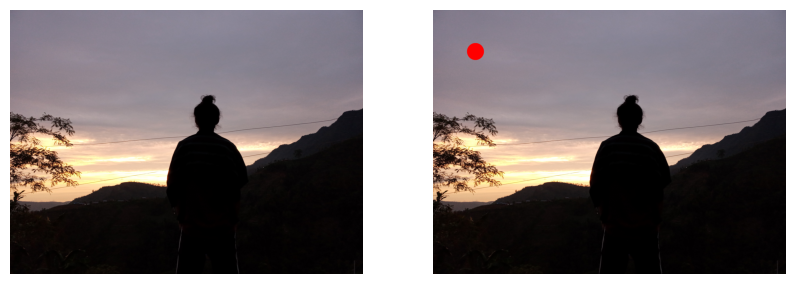

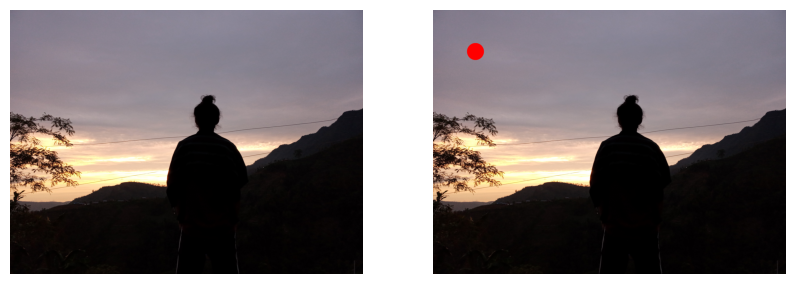

In [5]:
class BasePainter(ABC):
    def __init__(self):        
        pass
    @abstractmethod
    def paint(self, image = Union[np.ndarray, Image.Image]) -> Image.Image:
        pass

    @property
    def name(self):
        return f"{self.__class__.__name__}()"

    def __repr__(self) -> str:
        return self.name


class CirclePainter(BasePainter):
    def __init__(self, cv2_circle_args: Dict[str, Any]=
                 dict(center=(500, 500), radius=100, color=(255, 0, 0, 255), thickness=-2)):
        super().__init__()
        self.cv2_circle_args = cv2_circle_args

    def paint(self, image = Union[np.ndarray, Image.Image]) -> Image.Image:        
        if isinstance(image, Image.Image):
            image = np.array(image)

        cv2.circle(image, **self.cv2_circle_args)
        image = Image.fromarray(image)
        return image

img = Image.open("../assets/me.jpg")
painted = CirclePainter().paint(img)
subplot_images([img, painted], fig_size=(10, 5), order=(1, 2), show=True)

## Base Layer

Executor: ImageFlip(), Remaining: 3
Executor: Child1, Remaining: 2
Executor: GChild1, Remaining: 1
Executor: ImageRotate(), Remaining: 0
Executor: Child2, Remaining: 1
Executor: AlphaModifier(), Remaining: 0
Executor: Child3, Remaining: 0
Executor: CirclePainter(), Remaining: 1
Executor: ImageTranslator(), Remaining: 0
Executor: ImageTranslator(), Remaining: 0
Executor: ImageTranslator(), Remaining: 0
Executor: ImageTranslator(), Remaining: 0
Executor: ImageTranslator(), Remaining: 0


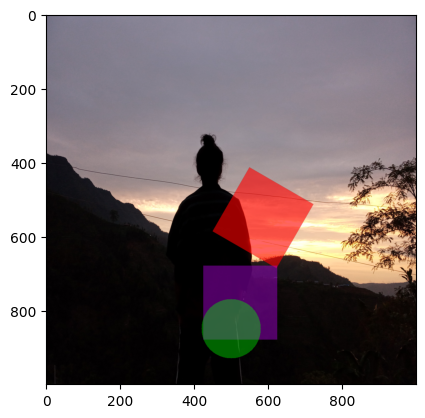

In [6]:
import matplotlib.pyplot as plt
from PIL import Image
from typing import Optional
from anytree import Node

class BaseLayer:
    def __init__(self, config: BaseLayerConfig=BaseLayerConfig()) -> None:
        self.config = config
        self._parent:'BaseLayer' = None
        self._children:List['BaseLayer'] = []
        self.layer_id = 0
        self._executors: Union[List['BaseLayer'], List[BaseModifier]] = []
        self._layer = None
        self.is_baked = False
        self._modifiers:List[BaseModifier] = []
        self.bake_order = []
        self._node = Node(self.name)
        self.steps=1
        self.baking_history = []

    @property
    def name(self) -> str:
        return self.config.name
    @property
    def parent(self) -> 'BaseLayer':
        return self._parent

    @parent.setter
    def parent(self, parent:'BaseLayer'):
        if self.config.allow_parent:
            self._parent = parent
        else:
            raise ValueError("This layer does not allow a parent")

    @property
    def children(self) -> List['BaseLayer']:
        return self._children

    @property
    def executors(self) -> List[Union['BaseLayer', BaseModifier]]:
        return self._executors

    @property
    def modifiers(self) -> List[BaseModifier]:
        return self._modifiers

    @property
    def id(self) -> int:
        return self.layer_id

    @property
    def layer(self) -> Image.Image:
        return self._layer

    def __str__(self):
        return self.config.name

    def __repr__(self):
        from anytree import RenderTree
        res = ''
        for pre, fill, node in RenderTree(self.node):
            # print("%s%s" % (pre, node.name))
            res += f"{pre}{node.name}\n"
        return res


    @property
    def node(self) -> Node:
        if self.parent is None:
            self._node = Node(self.name)
        else:
            self._node = Node(self.name, parent=self.parent._node)
        
        for executor in self.executors:
            if isinstance(executor, BaseLayer):
                executor.node
            else:
                executor._node = Node(executor.name, parent=self._node)
        return self._node
    
    def _init_layer(self) -> 'BaseLayer':
        if isinstance(self.config.layer_background, Path):
            with Image.open(self.config.layer_background) as img:
                # Convert image to RGBA if it is not
                img = img.convert("RGBA")
                if self.config.resize_if_needed:
                    img = img.resize(self.config.layer_size)
                background = np.array(img)
                background[
                    ..., 3
                ]=self.config.layer_alpha

        elif isinstance(self.config.layer_background, Tuple):
            background = np.zeros((*self.config.layer_size,3), dtype=np.uint8)
            background[:]=self.config.layer_background
            background = np.dstack((background, np.full(self.config.layer_size, self.config.layer_alpha, dtype=np.uint8)))
        self.background = background
        self._layer = Image.fromarray(self.background.copy())
        return self

    def bake_layer(self) -> 'BaseLayer':
        self._init_layer()
        remaining_executors = self.executors.copy()
        while len(remaining_executors)!=0:
        # for executor in self.executors:
            executor = remaining_executors.pop(0)
            print(f"Executor: {executor}, Remaining: {len(remaining_executors)}")  
            if isinstance(executor, BaseLayer):
                executor.bake_layer()
                self._layer.alpha_composite(executor.layer, executor.config.layer_position)
            elif isinstance(executor, BaseModifier):
                    self._layer = executor.modify(self._layer)
            elif isinstance(executor, BasePainter):
                self._layer = executor.paint(self._layer)
            elif isinstance(executor, BaseTransformer):
                if not executor.is_parallel:
                    for i in range(executor.steps):
                        self._layer = executor.transform(self._layer)
                else:
                    self._layer = executor.transform(self._layer)
                    if executor.current_step < executor.steps:
                        remaining_executors.append(executor)                
            else:
                raise ValueError(f"Executor {executor} is not supported")
            self.baking_history.append(self._layer.copy())

        self.is_baked = True
        return self
    def show_layer(self, layer:Optional[Image.Image]=None):
        if layer is not None:
            plt.imshow(layer)
            plt.show()
            return
        if not self.is_baked:
            self.bake_layer()
        plt.imshow(self.layer)
        plt.show()

    def add_child(self, child:'BaseLayer') -> 'BaseLayer':
        if self.config.allow_children:
            child.layer_id = len(self.children)
            self._children.append(child)
            child.parent = self
            self.executors.append(child)
        return self

    def remove_child(self, child:'BaseLayer') -> 'BaseLayer':
        if child in self.children:
            self._children.remove(child)
            child.parent = None
        return self

    def add_modifier(self, modifier:List[BaseModifier]) -> 'BaseLayer':
        for mod in modifier:
            mod.parent = self
        self._modifiers.extend(modifier)
        self._executors.extend(modifier)
        return self

    def remove_modifier(self, modifier:List[BaseModifier]) -> 'BaseLayer':
        if modifier in self.modifiers:
            self._modifiers.remove(modifier)
        return self

    def add_transformer(self, transformer:List[BaseTransformer]) -> 'BaseLayer':
        for tr in transformer:
            tr.parent = self
        self._executors.extend(transformer)
        
        return self
    
    def remove_transformer(self, transformer:List[BaseTransformer]) -> 'BaseLayer':
        if transformer in self.executors:
            self._executors.remove(transformer)
        return self

bl = BaseLayer(BaseLayerConfig())
bl.add_modifier([ImageFlip()])
bl.add_child(
    BaseLayer(BaseLayerConfig(name='Child1', layer_background=(0, 0, 0), layer_alpha=0, resize_if_needed=False)).add_child(
        BaseLayer(BaseLayerConfig(name="GChild1", layer_background=(255, 0, 0), layer_alpha=155, layer_position=(400, 500), 
                                       resize_if_needed=False, layer_size=(200, 200))
             )).add_modifier([ImageRotate(60)]))
bl.add_child(
    BaseLayer(BaseLayerConfig(name="Child2", layer_background=(200, 0, 255), layer_alpha=200, layer_position=(425, 680), 
                                       resize_if_needed=False, layer_size=(200, 200))
             ).add_modifier([AlphaModifier(100)]))
bl.add_child(
    BaseLayer(
        BaseLayerConfig(
            name="Child3",
            layer_background=(0, 0, 0),
            layer_alpha=0,
            resize_if_needed=False,
        )
    )
    .add_modifier(
        [
            CirclePainter(
                cv2_circle_args=dict(
                    thickness=-5, color=(0, 255, 0, 100), radius=80, center=(400, 650)
                )
            )
        ]
    )
    .add_transformer([ImageTranslator(x=10, y=20, steps=5, is_parallel=True)])
)
bl.show_layer()

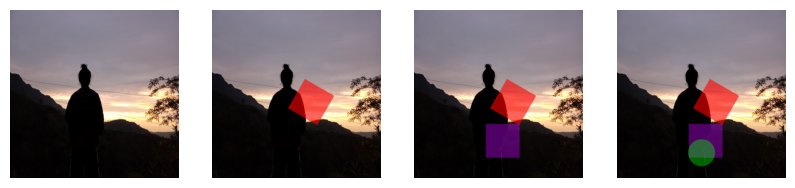

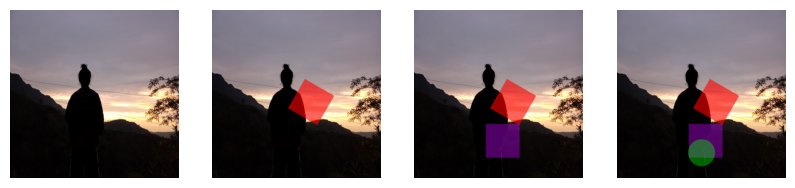

In [7]:
subplot_images(bl.baking_history[:], order=(1,-1))

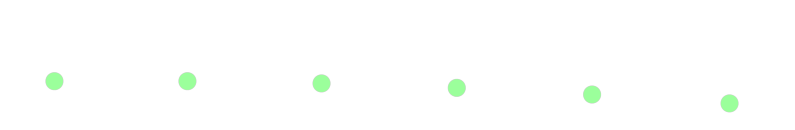

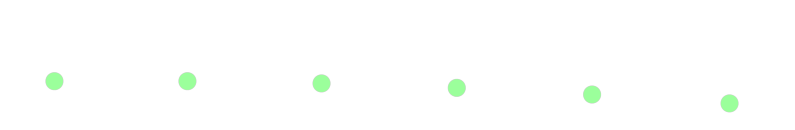

In [8]:
subplot_images(bl.children[2].baking_history, order=(1,-1))